In [1]:
import sys, os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt



In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob, c_gamma_sf, c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [3]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')
c_multi_gamma_prob_v1d_x = jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0)
c_multi_gamma_sf_v1d_x = jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0)

In [286]:
dist = 2.0
z = -500
rho = 0.0
zenith = 1.57
azimuth = 3.9264083

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

In [287]:
from lib.c_mpe_gamma import c_multi_gamma_mpe_prob
convolved_mpe_triple_gamma_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob, (0, None, None, None, None, None), 0))

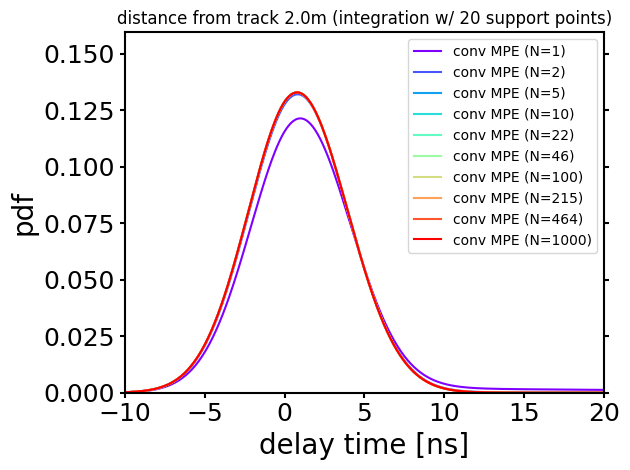

In [288]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = convolved_mpe_triple_gamma_v1d_x(xvals, logits, gamma_a, gamma_b, n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-10, 20],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.show()

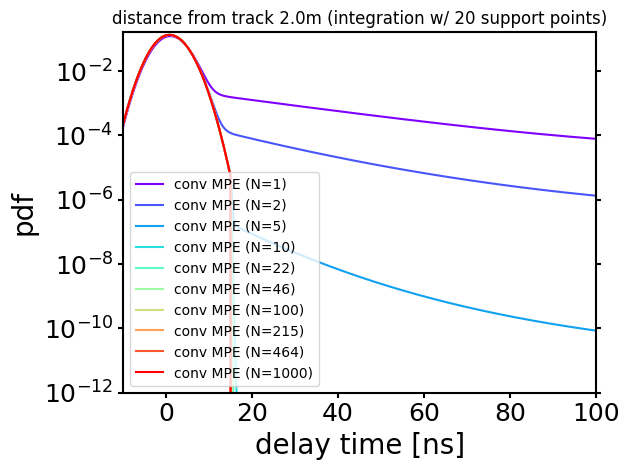

In [289]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 100, 1000)

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = convolved_mpe_triple_gamma_v1d_x(xvals, logits, gamma_a, gamma_b, n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-10, 100],
                     'ylim':[1.e-12, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_yscale('log')
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.show()

In [290]:
from jax.scipy.stats.gamma import sf as gamma_sf
from jax.scipy.stats.norm import pdf as norm_pdf

def c_multi_gamma_mpe_prob_pure_jax(x, mix_probs, a, b, n, sigma=3.0):
    nmax = 8
    nint = 8
    eps = 1.e-6

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))
    
    xvals = jnp.linspace(xmin+eps, xmax, nint)
    n_pdf = norm_pdf(0.5*(xvals[:-1]+xvals[1:]), loc=x, scale=sigma)

    a_e = jnp.expand_dims(gamma_a, axis=-1)
    b_e = jnp.expand_dims(gamma_b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)
    
    xvals_e = jnp.expand_dims(xvals, axis=0)
    sfs = jnp.sum(mix_probs_e * gamma_sf(xvals_e, a_e, scale=1./b_e), axis=0)
    sfs_power_n = jnp.power(sfs, n)
    return jnp.sum(n_pdf * (sfs_power_n[:-1]-sfs_power_n[1:]))

c_multi_gamma_mpe_prob_pure_jax_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax, 
                                                         (0, None, None, None, None, None), 
                                                         0))

def c_multi_gamma_mpe_prob_pure_jax2(x, mix_probs, a, b, n, sigma=3.0):
    nmax = 3.5
    nint = 5
    eps = 1.e-6
    split_point = 1.0
    
    # integrate around gaussian region
    xmin = jnp.max(jnp.array([split_point, x - nmax * sigma]))
    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    
    xvals = jnp.linspace(xmin, xmax, nint)
    n_pdf = norm_pdf(0.5*(xvals[:-1]+xvals[1:]), loc=x, scale=sigma)

    a_e = jnp.expand_dims(gamma_a, axis=-1)
    b_e = jnp.expand_dims(gamma_b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)
    
    xvals_e = jnp.expand_dims(xvals, axis=0)
    sfs = jnp.sum(mix_probs_e * gamma_sf(xvals_e, a_e, scale=1./b_e), axis=0)
    sfs_power_n = jnp.power(sfs, n)
    gaussian_region = jnp.sum(n_pdf * (sfs_power_n[:-1]-sfs_power_n[1:]))
    gaussian_region = jnp.clip(gaussian_region, min=0.0)

    # integrate before gaussian region
    xvals = jnp.linspace(eps, split_point, nint)
    xvals_e = jnp.expand_dims(xvals, axis=0)
    n_pdf = norm_pdf(0.5*(xvals[:-1]+xvals[1:]), loc=x, scale=sigma)
    sfs = jnp.sum(mix_probs_e * gamma_sf(xvals_e, a_e, scale=1./b_e), axis=0)
    sfs_power_n = jnp.power(sfs, n)
    before_region = jnp.sum(n_pdf * (sfs_power_n[:-1]-sfs_power_n[1:]))
    before_region = jnp.clip(before_region, min=0.0)
    
    return gaussian_region+before_region

c_multi_gamma_mpe_prob_pure_jax2_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax2, 
                                                         (0, None, None, None, None, None), 
                                                         0))

In [291]:
print(c_multi_gamma_mpe_prob_pure_jax2(15.1, mix_probs, gamma_a, gamma_b, 1000))

5.165897126196681e-07


In [292]:
print(c_multi_gamma_mpe_prob_pure_jax(15.1, mix_probs, gamma_a, gamma_b, 1000))

2.9461868030236666e-05


In [293]:
print(c_multi_gamma_mpe_prob(0.0, logits, gamma_a, gamma_b, 1000, 3.0))

0.12887652893192


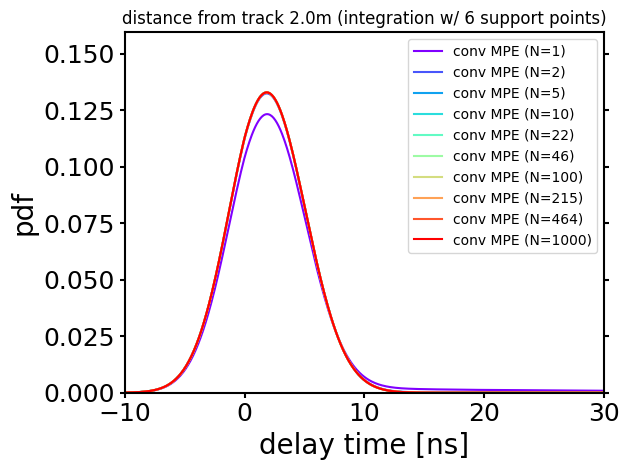

In [294]:
fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = c_multi_gamma_mpe_prob_pure_jax_v1d_x(xvals, mix_probs, gamma_a, gamma_b, n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-10, 30],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m (integration w/ 6 support points)")
plt.tight_layout()
plt.show()

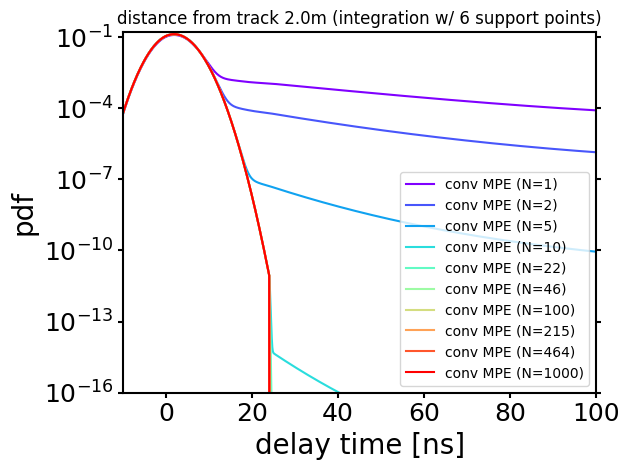

In [295]:
fig, ax = plt.subplots()
xvals = np.linspace(-20, 100, 1000)

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = c_multi_gamma_mpe_prob_pure_jax_v1d_x(xvals, mix_probs, gamma_a, gamma_b, n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-10, 100],
                     'ylim':[1.e-16, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_yscale('log')
plt.title(f"distance from track {dist:.1f}m (integration w/ 6 support points)")
plt.tight_layout()
plt.show()

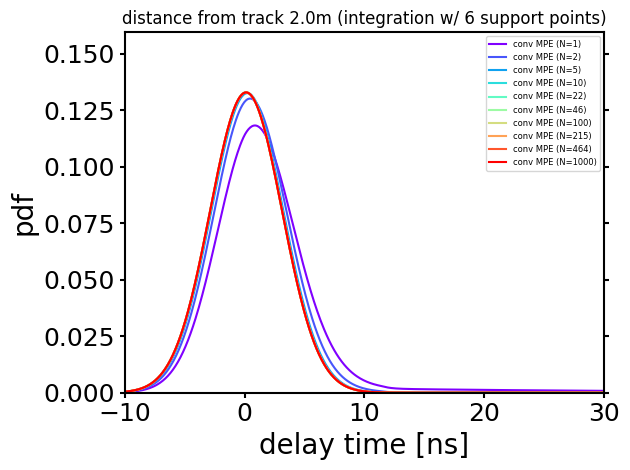

In [296]:
fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = c_multi_gamma_mpe_prob_pure_jax2_v1d_x(xvals, mix_probs, gamma_a, gamma_b, n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    #ys = c_multi_gamma_mpe_prob_pure_jax_v1d_x(xvals, mix_probs, gamma_a, gamma_b, n_p, jnp.array(3.0))
    #plt.plot(xvals, ys, color=color[i], linestyle='dashed')
    y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-10, 30],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.legend(fontsize=6)
plt.title(f"distance from track {dist:.1f}m (integration w/ 6 support points)")
plt.tight_layout()
plt.show()

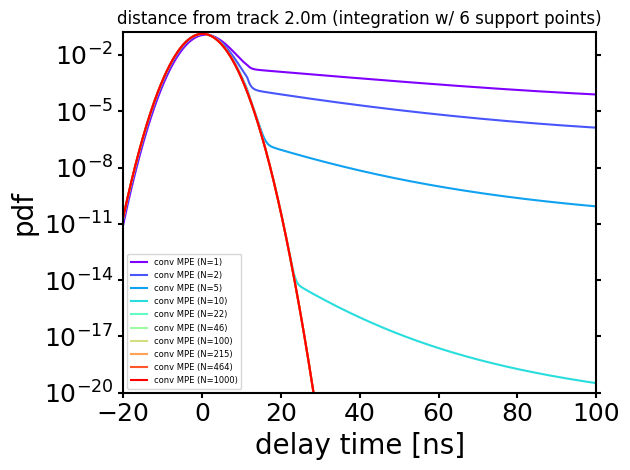

In [297]:
fig, ax = plt.subplots()
xvals = np.linspace(-20, 100, 1000)

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = c_multi_gamma_mpe_prob_pure_jax2_v1d_x(xvals, mix_probs, gamma_a, gamma_b, n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    #ys = c_multi_gamma_mpe_prob_pure_jax_v1d_x(xvals, mix_probs, gamma_a, gamma_b, n_p, jnp.array(3.0))
    #plt.plot(xvals, ys, color=color[i], linestyle='dashed')
    y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-20, 100],
                     'ylim':[1.e-20, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_yscale('log')
ax.legend(fontsize=6)
plt.title(f"distance from track {dist:.1f}m (integration w/ 6 support points)")
plt.tight_layout()
plt.show()

In [261]:
print(c_multi_gamma_mpe_prob_pure_jax(15, mix_probs, gamma_a, gamma_b, n_p, jnp.array(2.0)))

0.0


In [262]:
from jax.scipy.stats.gamma import logsf as gamma_logsf

In [263]:
power=1000
x = 15
print(gamma_sf(x, gamma_a[0], scale=1/gamma_b[0])**power)
print(jnp.exp(power * gamma_logsf(x, gamma_a[0], scale=1/gamma_b[0])))

5.406746164747353e-220
5.4067461647467676e-220


In [264]:
print(mix_probs)

[0.23851301 0.68635697 0.07513003]


In [206]:
def func(x, a, b, n):
    return jnp.power(gamma_sf(x, a, scale=1./b), n)

func_grad = jax.grad(func)
func_grad_v = jax.vmap(func_grad, (0, None, None, None), 0)

In [207]:
def c_multi_gamma_mpe_prob_pure_jax2(x, mix_probs, a, b, n, sigma=3.0):
    nmax = 3
    nint = 7
    eps = 1.e-6

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))
    xmin = jnp.array(0.0)
    
    xvals = jnp.linspace(xmin, xmax, nint)
    xvals = 0.5*(xvals[:-1]+xvals[1:])
    
    n_pdf = norm_pdf(xvals, loc=x, scale=sigma)

    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)
    #dtp_power_n = func_grad_v_v(xvals, a, b, n)
    dtp_power_n_0 = jnp.expand_dims(func_grad_v(xvals, a[0], b[0], n), axis=0)
    dtp_power_n_1 = jnp.expand_dims(func_grad_v(xvals, a[1], b[1], n), axis=0)
    dtp_power_n_2 = jnp.expand_dims(func_grad_v(xvals, a[2], b[2], n), axis=0)
    dtp_power_n = jnp.concatenate([dtp_power_n_0, dtp_power_n_1, dtp_power_n_2], axis=0)
    dtp = jnp.sum(mix_probs_e * dtp_power_n, axis=0)
    
    return -jnp.sum(n_pdf * dtp) * (xvals[1]-xvals[0])

c_multi_gamma_mpe_prob_pure_jax2_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax2, 
                                                         (0, None, None, None, None, None), 
                                                         0))

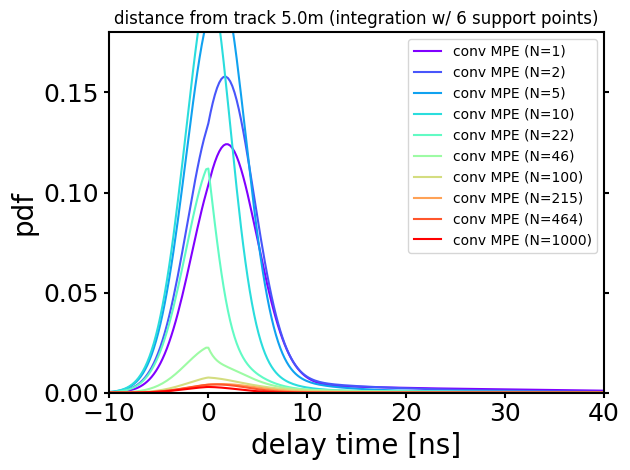

In [208]:
fig, ax = plt.subplots()
xvals = np.linspace(-20, 200, 1000)

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = c_multi_gamma_mpe_prob_pure_jax2_v1d_x(xvals, mix_probs, gamma_a, gamma_b, n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])

y_max = 0.15
plot_args = {'xlim':[-10, 40],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m (integration w/ 6 support points)")
plt.tight_layout()
plt.show()

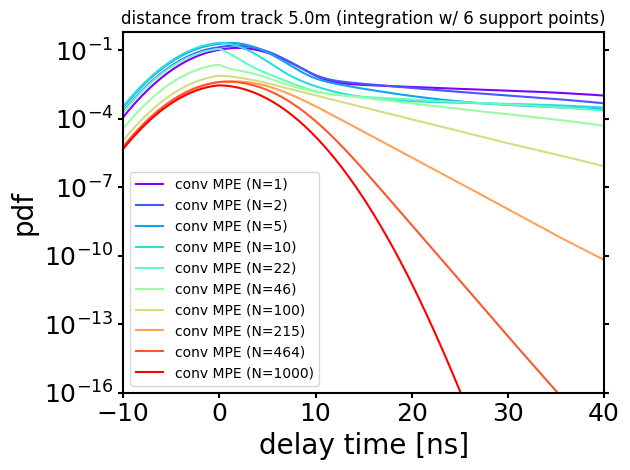

In [167]:
fig, ax = plt.subplots()
xvals = np.linspace(-20, 200, 1000)

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = c_multi_gamma_mpe_prob_pure_jax2_v1d_x(xvals, mix_probs, gamma_a, gamma_b, n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])

y_max = 0.5
plot_args = {'xlim':[-10, 40],
                     'ylim':[1.e-16, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_yscale('log')
plt.title(f"distance from track {dist:.1f}m (integration w/ 6 support points)")
plt.tight_layout()
plt.show()

In [168]:
c_multi_gamma_mpe_prob_pure_jax2(5.0, mix_probs, gamma_a, gamma_b, 10, sigma=3.0)

Array(0.03173337, dtype=float64)